In [287]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import scipy.stats as stats
from scipy.stats import shapiro, pearsonr
from itertools import combinations
import statsmodels.api as sm

plt.rcParams['font.family'] = 'AppleGothic'
plt.rc('axes',unicode_minus=False)

In [288]:
df = pd.read_csv('../datasets/listed_resampled_train_data.csv')

In [289]:
df.columns

Index(['회사명', '거래소코드', '회계년도', 'CASH FLOW 대 부채비율', 'CASH FLOW 대 차입금비율',
       'CASH FLOW 대 총자본비율', 'CASH FLOW 대 매출액비율', '유동비율', '당좌비율', '부채비율',
       '유동부채비율', '차입금의존도', '순운전자본비율', '현금비율', '유동자산구성비율', '자기자본구성비율',
       '자기자본순이익률', '경영자본순이익률', '매출액순이익률', '총자본사업이익률', '총자본영업이익률', '매출액영업이익률',
       '금융비용부담률', 'CROE', '총자산증가율', '총자본증가율', '유동자산증가율', '비유동자산증가율', '매출액증가율',
       '유형자산증가율', '부가가치', '총자본투자효율', '설비투자효율', '부가가치율', '이윤분배율', '자본분배율',
       '총자산회전율', '매출채권회전률', '당좌자산회전률', '유형자산회전율', '경영자본회전률', '총자본회전률',
       '비유동자산회전률', '유동자산회전률', '영업년수', '상장년수', 'PER', 'PBR', 'PCR', 'PSR',
       '쭈피처', '영업투자현금비율', '영업재무현금비율', '도입기', '성숙기', '성장기', '쇠퇴기', '부실판단'],
      dtype='object')

In [290]:
df = df.drop(columns=['회사명', '거래소코드', '회계년도', '도입기', '성숙기', '성장기', '쇠퇴기'])

In [291]:
# H가 1인 경우 이분산성 / H가 0인 경우 등분산
from scipy.stats import bartlett
def bartlett_test(col, p_value = 0.05, H = 1):
    list= []
    for i in col:
        T, p_val = bartlett(df[df['부실판단']==1][i], df[df['부실판단']==0][i]) 
        list.append([i, p_val])

    list = pd.DataFrame(list, columns = ['변수', 'p_value'])
    if H == 1:
        a = list[(list['p_value'] < p_value)][['변수', 'p_value']].sort_values('p_value')
        return a
    else:
        a = list[(list['p_value'] >= p_value)][['변수', 'p_value']].sort_values('p_value')
        return a

In [292]:
# 이분산성 변수
x_hetero = bartlett_test(df.columns, H = 1)
# 등분산성 변수
x_homo = bartlett_test(df.columns, H = 0)

In [293]:
# t-test

import scipy.stats as stats
def t_test(col, col_h0, col_h1, p_value = 0.05):
    list= []
    for i in col:
        if (col_h0['변수']==i).any():
            t_stat, p_val = stats.ttest_ind(df[df['부실판단']==1][i], df[df['부실판단']==0][i], equal_var=True) # 등분산성 : wald t-test
            list.append([i, p_val])
        elif (col_h1['변수']==i).any():
            t_stat, p_val = stats.ttest_ind(df[df['부실판단']==1][i], df[df['부실판단']==0][i], equal_var=False) # 이분산성 : welch’s t-test
            list.append([i, p_val])

    list = pd.DataFrame(list, columns = ['변수', 'p_value'])
    a = list[(list['p_value'] < p_value)][['변수', 'p_value']].sort_values('p_value')
    return a

In [294]:
# 2) t_test 결과 p_value < 0.05보다 작은 유의한 변수 가져오기
x_ttest = t_test(df.columns, x_homo, x_hetero, p_value=0.05)
print("유의한 피쳐 수 :", len(x_ttest))
x_ttest = x_ttest.sort_values(by="변수", ascending=True).reset_index(drop=True)
x_ttest

유의한 피쳐 수 : 26


,변수,p_value
0,CASH FLOW 대 매출액비율,4.258180e-05
1,CASH FLOW 대 부채비율,6.542252e-08
2,CASH FLOW 대 총자본비율,6.993837e-06
3,PCR,1.130790e-02
4,경영자본순이익률,2.982223e-11
5,금융비용부담률,2.856744e-07
6,당좌비율,5.804023e-03
7,매출액순이익률,3.090024e-10
8,매출액영업이익률,5.440246e-11
9,부가가치,1.521318e-06


In [295]:
ttest_list = list(x_ttest['변수'])

In [296]:
ttest_df = df[ttest_list]

In [297]:
ttest_df

,CASH FLOW 대 매출액비율,CASH FLOW 대 부채비율,CASH FLOW 대 총자본비율,PCR,경영자본순이익률,금융비용부담률,당좌비율,매출액순이익률,매출액영업이익률,부가가치,...,유동비율,유형자산회전율,이윤분배율,자기자본구성비율,자기자본순이익률,쭈피처,차입금의존도,총자본사업이익률,총자본영업이익률,총자본투자효율
0,-5.00,-16.0,-4.0,-12514.010611,3.20,0.18,177.00,2.92,3.34,10672.0,...,193.00,2.0,17.00,73.0,3.95,0.047854,13.0,3.40,3.20,16.0
1,-68.92,-12.0,-7.0,-56689.751703,-4.11,6.92,922.92,-30.27,-33.20,2757.0,...,1099.76,2.0,-126.00,39.0,-8.45,0.628340,54.0,-4.02,-4.35,2.0
2,-6.00,-6.0,-3.0,-53966.034471,5.00,0.74,174.00,8.56,3.38,24947.0,...,202.00,2.0,36.00,47.0,9.77,0.153646,30.0,2.32,1.79,13.0
3,-18.00,-14.0,-4.0,-88791.817582,-6.81,2.13,33.64,-24.91,-17.70,555.0,...,65.00,0.0,-613.48,68.0,-8.56,0.655450,27.0,-4.41,-4.44,1.0
4,-16.00,-13.0,-6.0,-5453.761960,-4.13,5.40,115.00,-10.06,-13.95,7913.0,...,174.00,3.0,-44.00,53.0,-7.15,0.331854,26.0,-5.08,-5.37,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,-3.00,-13.0,-2.0,-185653.852102,-4.48,-1.99,417.00,-5.32,-7.51,5849.0,...,486.00,44.0,-33.00,83.0,-4.00,0.459653,8.0,-3.37,-4.74,10.0
252,-9.00,-17.0,-12.0,-177227.253195,-4.19,2.90,94.00,-3.24,1.39,4000.0,...,122.00,12.0,-20.00,29.0,-14.51,0.148076,48.0,1.82,1.60,21.0
253,-10.00,-8.0,-6.0,-4095.149967,-17.71,5.63,39.00,-30.73,-24.41,1127.0,...,75.00,1.0,-709.00,31.0,-44.07,0.356385,40.0,-13.85,-13.90,2.0
254,-9.00,-6.0,-3.0,-12874.009040,-11.14,2.75,64.00,-33.53,-20.38,-1846.0,...,68.00,1.0,0.00,56.0,-17.68,0.110112,34.0,-6.11,-6.24,-3.0


### Wrapper 피처 셀렉션

In [298]:
wrapper_df = df

In [299]:
# 학습 데이터와 검증 데이터 분리
X_train = wrapper_df.drop(columns='부실판단')
y_train = wrapper_df['부실판단']

#### 스케일링

In [300]:
labels = X_train.columns

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(data=X_train, columns = labels)

In [301]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [302]:
sbs = SFS(LinearRegression(),
         k_features=(5,15),
         forward=False,
         floating=False,
         cv=0)
sbs.fit(X_train, y_train)
li_backward_feature_list = sbs.k_feature_names_

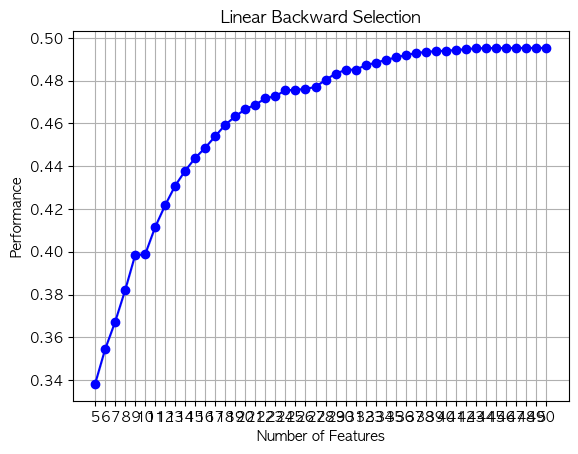

In [303]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
plt.title('Linear Backward Selection')
plt.grid()
plt.show()

In [322]:
li_backward_feature = list(li_backward_feature_list)
li_backward_feature_final_list = li_backward_feature[0:8]

In [305]:
#Sequential backward selection(sbs)
sbs = SFS(LogisticRegression(),
         k_features=(5,15),
         forward=False,
         floating=False,
         cv=0)
sbs.fit(X_train, y_train)
logit_backward_feature_list = sbs.k_feature_names_

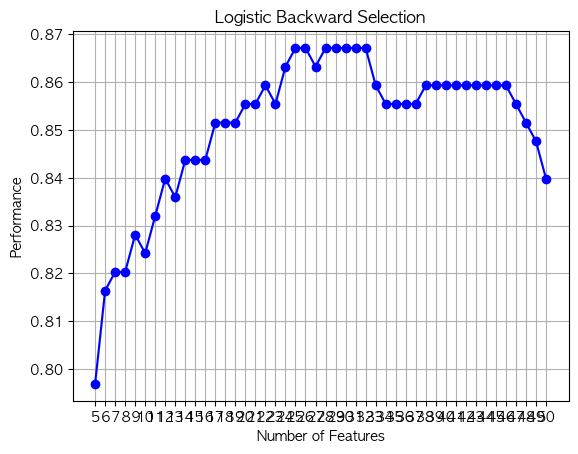

In [306]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
plt.title('Logistic Backward Selection')
plt.grid()
plt.show()

In [321]:
logit_backward_feature = list(logit_backward_feature_list)
logit_backward_feature_final_list = logit_backward_feature[0:11]

In [308]:
#Sequential backward selection(sbs)
sbs = SFS(RandomForestClassifier(max_depth=5),
         k_features=(5,15),
         forward=False,
         floating=False,
         cv=0)
sbs.fit(X_train, y_train)
RF_backward_feature_list = sbs.k_feature_names_

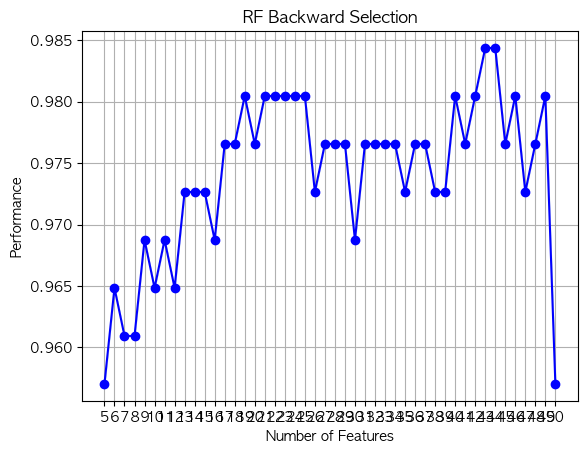

In [309]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
plt.title('RF Backward Selection')
plt.grid()
plt.show()

In [320]:
RF_backward_feature = list(RF_backward_feature_list)
RF_backward_feature_final_list = RF_backward_feature[0:12]

In [323]:
def func_Linear_Backward(x):
    if x in li_backward_feature_final_list:
        return 1
    else:
        return 0

def func_Logit_Backward(x):
    if x in logit_backward_feature_final_list:
        return 1
    else:
        return 0
    
def func_RF_Backward(x):
    if x in RF_backward_feature_final_list:
        return 1
    else:
        return 0

In [325]:
list_col_all = X_train.columns

# 중복 선택된 Feature
feature_counts = pd.DataFrame()
feature_counts['Feature'] = list_col_all
feature_counts['Linear Backward'] = list_col_all.map(func_Linear_Backward)
feature_counts['Logit Backward'] = list_col_all.map(func_Logit_Backward)
feature_counts['RF Backward'] = list_col_all.map(func_RF_Backward)

feature_counts["Backward Total"] = feature_counts['Linear Backward'] + feature_counts['Logit Backward'] + feature_counts['RF Backward']

backward_feature_final = feature_counts[feature_counts["Backward Total"]>=2]
list_feature_final = list(backward_feature_final["Feature"])
print("선택된 피쳐수 :", len(list_feature_final))
backward_feature_final

선택된 피쳐수 : 6


,Feature,Linear Backward,Logit Backward,RF Backward,Backward Total
0,CASH FLOW 대 부채비율,1,1,1,3
5,당좌비율,0,1,1,2
9,순운전자본비율,1,1,0,2
11,유동자산구성비율,0,1,1,2
19,금융비용부담률,1,1,0,2
31,이윤분배율,1,1,0,2


In [326]:
backward_feature = list(backward_feature_final['Feature'])
backward_feature

['CASH FLOW 대 부채비율', '당좌비율', '순운전자본비율', '유동자산구성비율', '금융비용부담률', '이윤분배율']

### Embedded : Lasso

In [331]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha= 0.028, max_iter = 10000).fit(X_train, y_train)
feature_list = lasso.feature_names_in_[lasso.coef_ != 0]

lasso_feature_list = feature_list
len(lasso_feature_list)

14

### Ttest, Backward, Lasso 중첩 feature 확인

In [332]:
def func_Ttest(x):
    if x in ttest_list:
        return 1
    else:
        return 0
    
def func_Backward(x):
    if x in backward_feature:
        return 1
    else:
        return 0
    
def func_lasso(x):
    if x in lasso_feature_list:
        return 1
    else:
        return 0

In [333]:
list_col_all = X_train.columns

# 중복 선택된 Feature
feature_counts = pd.DataFrame()
feature_counts['Feature'] = list_col_all
feature_counts['Ttest'] = list_col_all.map(func_Ttest)
feature_counts['Backward'] = list_col_all.map(func_Backward)
feature_counts['Lasso'] = list_col_all.map(func_lasso)

feature_counts["Total"] = feature_counts["Ttest"]+feature_counts['Backward']+feature_counts["Lasso"]

feature_final = feature_counts[feature_counts["Total"]>=2]
list_feature_final = list(feature_final["Feature"])
print("선택된 피쳐수 :", len(list_feature_final))
feature_final

선택된 피쳐수 : 13


,Feature,Ttest,Backward,Lasso,Total
0,CASH FLOW 대 부채비율,1,1,1,3
5,당좌비율,1,1,0,2
9,순운전자본비율,1,1,1,3
12,자기자본구성비율,1,0,1,2
14,경영자본순이익률,1,0,1,2
17,총자본영업이익률,1,0,1,2
18,매출액영업이익률,1,0,1,2
19,금융비용부담률,1,1,1,3
31,이윤분배율,1,1,0,2
36,유형자산회전율,1,0,1,2
